In [1]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
import skimage

from skimage.feature import hog
from skimage.feature import canny
from skimage import data, exposure
from skimage.exposure import histogram
from skimage.feature import match_template
from skimage.transform import rescale
from skimage.util import random_noise
from scipy.signal import correlate2d
from skimage import io
from skimage.transform import resize

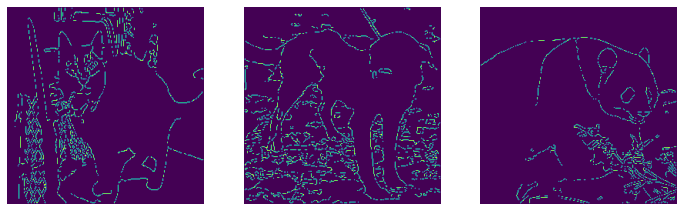

In [2]:
size = 256

sigma_value = 2
low_threshold_value = 0.1
high_threshold_value = 0.3

pixels_per_cell_value = 8
cells_per_block_value = 1

number_of_animals_to_compare = 10
animal_type = "dogs/dogs"

#Instancie le dataset dans 3 list, on les converties en silhouette simultanément
cats = [resize(canny(io.imread(f"animals/cats/cats_0000{idx}.jpg", as_gray=True), sigma=sigma_value, low_threshold=low_threshold_value, high_threshold=high_threshold_value), (size, size)) for idx in range(1,6)]
dogs = [resize(canny(io.imread(f"animals/dogs/dogs_0000{idx}.jpg", as_gray=True), sigma=sigma_value, low_threshold=low_threshold_value, high_threshold=high_threshold_value), (size, size)) for idx in range(1,6)]
pandas = [resize(canny(io.imread(f"animals/pandas/panda_0000{idx}.jpg", as_gray=True), sigma=sigma_value, low_threshold=low_threshold_value, high_threshold=high_threshold_value), (size, size)) for idx in range(1,6)]
images = cats + dogs + pandas

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axes[0].imshow(cats[0]) and axes[0].axis('off')
axes[1].imshow(dogs[0]) and axes[1].axis('off')
axes[2].imshow(pandas[0]) and axes[2].axis('off')

plt.show()

In [3]:

cats_hog = [hog(img, orientations=8, pixels_per_cell=(pixels_per_cell_value, pixels_per_cell_value),
                    cells_per_block=(cells_per_block_value, cells_per_block_value)) for img in cats]
dogs_hog = [hog(img, orientations=8, pixels_per_cell=(pixels_per_cell_value, pixels_per_cell_value),
                    cells_per_block=(cells_per_block_value, cells_per_block_value)) for img in dogs]
pandas_hog = [hog(img, orientations=8, pixels_per_cell=(pixels_per_cell_value, pixels_per_cell_value),
                    cells_per_block=(cells_per_block_value, cells_per_block_value)) for img in pandas]

# étiquettes (1 pour les chats, 2 pour les chiens, 3 pour les pandas)
cats_labels = 1 * np.ones((len(cats_hog), ))
dogs_labels = 2 * np.ones((len(dogs_hog), ))
pandas_labels = 3 * np.ones((len(pandas_hog), ))

dataset = np.concatenate((cats_hog, dogs_hog, pandas_hog))
labels = np.concatenate((cats_labels, dogs_labels, pandas_labels)).astype("int")
print(labels.shape)

(15,)


In [4]:
query = [resize(canny(io.imread(f"animals/{animal_type}_0000{idx}.jpg", as_gray=True), sigma=sigma_value, low_threshold=low_threshold_value, high_threshold=high_threshold_value), (size, size)) for idx in range(1,number_of_animals_to_compare)]
hog_query = [hog(img, orientations=8, pixels_per_cell=(pixels_per_cell_value, pixels_per_cell_value), cells_per_block=(cells_per_block_value, cells_per_block_value))for img in query]
plt.show()

Étiquettes des 5 images les plus proches : [2 3 3 1 3]
Étiquette majoritaire : 3
Étiquettes des 5 images les plus proches : [2 1 1 2 1]
Étiquette majoritaire : 1
Étiquettes des 5 images les plus proches : [2 1 1 3 1]
Étiquette majoritaire : 1
Étiquettes des 5 images les plus proches : [2 1 1 1 3]
Étiquette majoritaire : 1
Étiquettes des 5 images les plus proches : [2 3 3 3 2]
Étiquette majoritaire : 3
Étiquettes des 5 images les plus proches : [1 1 2 1 2]
Étiquette majoritaire : 1
Étiquettes des 5 images les plus proches : [1 1 3 2 2]
Étiquette majoritaire : 1
Étiquettes des 5 images les plus proches : [1 1 3 2 1]
Étiquette majoritaire : 1
Étiquettes des 5 images les plus proches : [1 2 1 3 1]
Étiquette majoritaire : 1
Le pourcentage de détection est de : 0.0


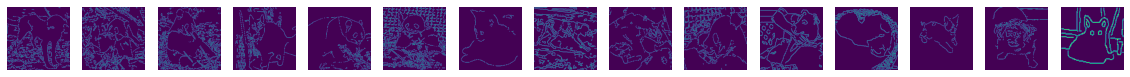

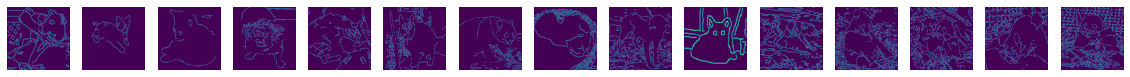

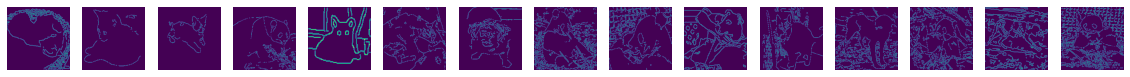

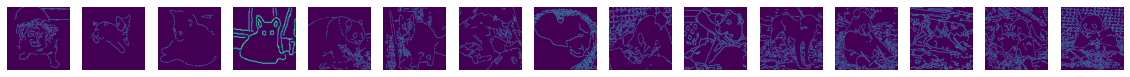

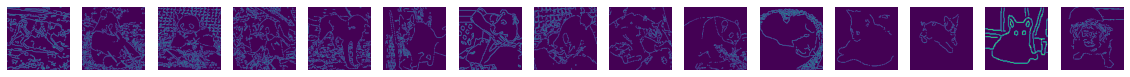

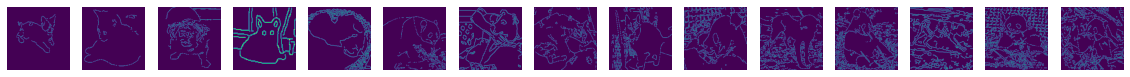

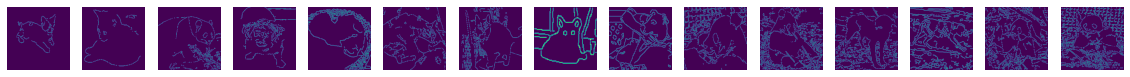

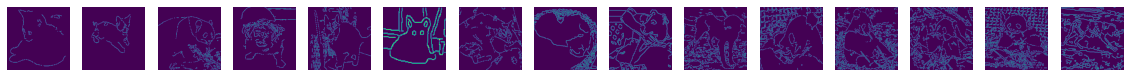

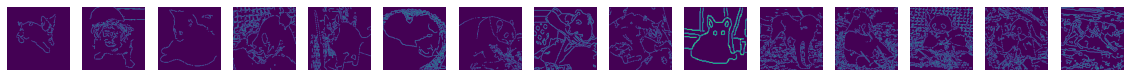

In [5]:
total = number_of_animals_to_compare - 1
true_positive = 0
#Je compare toutes les images de la liste crée avec le dataset d'images.
for img in hog_query :
    scores = np.array([np.linalg.norm(img - hog) for hog in dataset])

    closest = np.argsort(scores)
    fig, axes = plt.subplots(nrows=1, ncols=len(closest), figsize=(20, 8))
    for idx, img_idx in enumerate(closest):
        axes[idx].imshow(images[img_idx]) and axes[idx].axis('off')

    k = 5
    closest_labels = labels[closest[:k]]
    #Check si le resultat est un vrai positif.
    match animal_type:
        case "cats/cats":
            if np.argmax(np.bincount(closest_labels)) == 1:
                true_positive += 1
        case "dogs/dogs":
            if np.argmax(np.bincount(closest_labels)) == 2:
                true_positive += 1
        case "pandas/panda":
            if np.argmax(np.bincount(closest_labels)) == 3:
                true_positive += 1
    print(f"Étiquettes des {k} images les plus proches : {closest_labels}")
    print(f"Étiquette majoritaire : {np.argmax(np.bincount(closest_labels))}")
print(f"Le pourcentage de détection est de : {true_positive / total * 100}")

La detection des chats est très efficace quand on compare les images avec un canny. La détection des pandas arrive à un taux acceptable (± 60%) quand on ajuste les thresholds du canny (en les augmentants) au détriment de la détection des chats (mais elle reste tous a fais acceptable ± 60%). Cependant, la détection des chiens est médiocre montant jusqu'à ± 20% quelque soit les settings.